In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from astropy.coordinates import SkyCoord
from astropy import units as u
from tqdm.notebook import tqdm
from DS_models_stat import cut_cat

In [2]:
def make_histogram(ax, tp, fp, n_bins, label1='Yes matches', label2='No matches'):
    ax.hist(tp, n_bins, color='r', log=True, histtype='step', label=label1)
    ax.hist(fp, n_bins, color='b', log=True, histtype='step', label=label2)
    ax.legend()

In [7]:
    '''
def match_2circles(ax, det_cat, true_cat, n_bins=20, small_circle=400/3600, big_circle=1500/3600, max_pred_lim=None, 
                  b_lim=None, big_pix=None):
    if not (max_pred_lim is None):
        det_cat = det_cat[det_cat['max_pred'] >= max_pred_lim]
        det_cat.index = np.arange(len(det_cat))
        
    if not (big_pix is None):
        pix2 = radec2pix(det_cat['RA'], det_cat['DEC'], 2)
        det_cat = det_cat[np.in1d(pix2, big_pix)]
        det_cat.index = np.arange(len(det_cat))
        pix2 = radec2pix(true_cat['RA'], true_cat['DEC'], 2)
        true_cat = true_cat[np.in1d(pix2, big_pix)]
        true_cat.index = np.arange(len(true_cat))
    det_sc = SkyCoord(ra=np.array(det_cat['RA'])*u.degree, dec=np.array(det_cat['DEC'])*u.degree, frame='icrs')
    tr_sc = SkyCoord(ra=np.array(true_cat['RA'])*u.degree, dec=np.array(true_cat['DEC'])*u.degree, frame='icrs')
    
    if not (b_lim is None):
        b = det_sc.galactic.b.degree
        det_cat = det_cat[np.abs(b) >= b_lim]
        det_cat.index = np.arange(len(det_cat))
        det_sc = SkyCoord(ra=np.array(det_cat['RA'])*u.degree, dec=np.array(det_cat['DEC'])*u.degree, frame='icrs')
        b = tr_sc.galactic.b.degree
        true_cat = true_cat[np.abs(b) >= b_lim]
        true_cat.index = np.arange(len(true_cat))
        tr_sc = SkyCoord(ra=np.array(true_cat['RA'])*u.degree, dec=np.array(true_cat['DEC'])*u.degree, frame='icrs')
            
   
    idx_s, d2d, _ = det_sc.match_to_catalog_sky(tr_sc)
    matched_small = d2d.degree <= small_circle
    while np.count_nonzero(d2d.degree < small_circle):
        matched_small = np.concatenate([matched_small, d2d.degree <= small_circle])
        not_matched_small = np.logical_not(matched_small) 
        tr_sc = SkyCoord(ra=np.array(true_cat['RA'][list(set(idx[not_matched_small]))])*u.degree, 
                         dec=np.array(true_cat['DEC'][list(set(idx[not_matched_small]))])*u.degree, frame='icrs')
        idx, d2d, _ = det_sc.match_to_catalog_sky(tr_sc)
        idx_s = np.concatenate([idx_s, idx])
    
    tr_sc = SkyCoord(ra=np.array(true_cat['RA'][list(set(idx[not_matched_small]))])*u.degree, 
                     dec=np.array(true_cat['DEC'][list(set(idx[not_matched_small]))])*u.degree, frame='icrs')
    idx, d2d, _ = det_sc.match_to_catalog_sky(tr_sc)
    matched_big = np.logical_and(d2d.degree > small_circle, d2d.degree <= big_circle)
    
    
    make_histogram(ax, det_cat['max_pred'][matched_small], det_cat['max_pred'][matched_big], n_bins)
    '''

In [3]:
dirname = '/home/rt2122/Data/original_catalogs/csv/'
true_cats = next(os.walk(dirname))[-1]
true_cats = [os.path.join(dirname, s) for s in true_cats]
det_cat = '/home/rt2122/Data/detected_cats/full_pz_all_found34_thr0.1_step8_no_fn.csv'

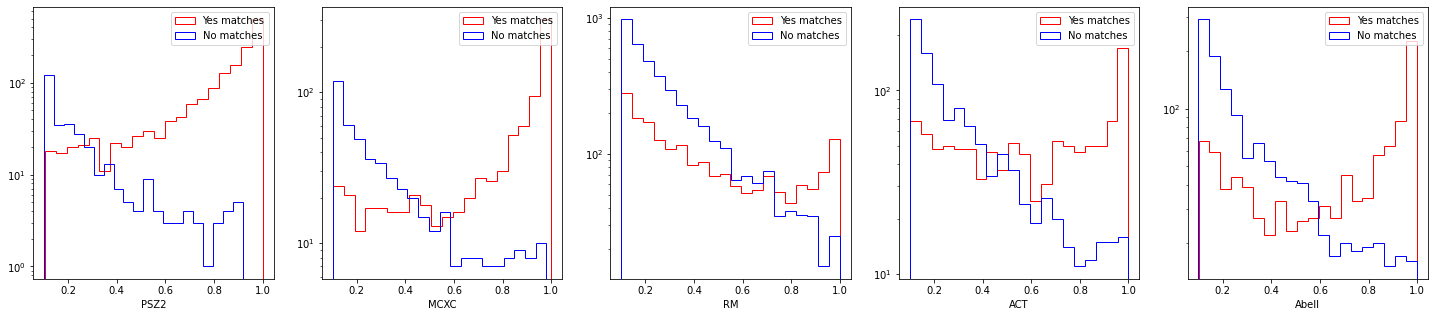

In [11]:
_, ax = plt.subplots(1, len(true_cats), figsize=(len(true_cats) * 5, 5))
for i, tr_cat in enumerate(true_cats):
    match_2circles(ax[i], pd.read_csv(det_cat), pd.read_csv(tr_cat))
    ax[i].set_xlabel(os.path.splitext(os.path.basename(tr_cat))[0])

In [23]:
def match_one_by_one(ax, det_cat, true_cat, small_circle=400/3600, big_circle=1500/3600, name=None):
    
    def func(angle, det_cat, true_cat):
        colored = []
        tr = SkyCoord(ra=np.array(true_cat['RA'])*u.degree, dec=np.array(true_cat['DEC'])*u.degree, frame='icrs')

        for i in tqdm(range(len(det_cat))):
            det = SkyCoord(ra=det_cat.loc[i, 'RA']*u.degree, dec=det_cat.loc[i, 'DEC']*u.degree, frame='icrs')
            sep = tr.separation(det).degree

            count = np.count_nonzero(sep <= angle)
            colored.extend(count * [det_cat.loc[i, 'max_pred']])

            true_cat = true_cat[sep > angle]
            if len(tr_cat) == 0:
                break
            true_cat.index = np.arange(len(true_cat))
            tr = SkyCoord(ra=np.array(true_cat['RA'])*u.degree, dec=np.array(true_cat['DEC'])*u.degree, frame='icrs')
        return colored, true_cat
    
    filered = '/home/rt2122/Data/cur/redblue/{}_red.npy'.format(name)
    fileblue = '/home/rt2122/Data/cur/redblue/{}_blue.npy'.format(name)

    if os.path.isfile(filered):
        red = np.load(filered)
        blue = np.load(fileblue)
    else:
        red, true_cat = func(small_circle, det_cat, true_cat)
        blue, true_cat = func(big_circle, det_cat, true_cat)

        if not (name is None):
            np.save(filered, np.array(red))
            np.save(fileblue, np.array(blue))
    
    make_histogram(ax, red, blue, 20, 'red', 'blue')

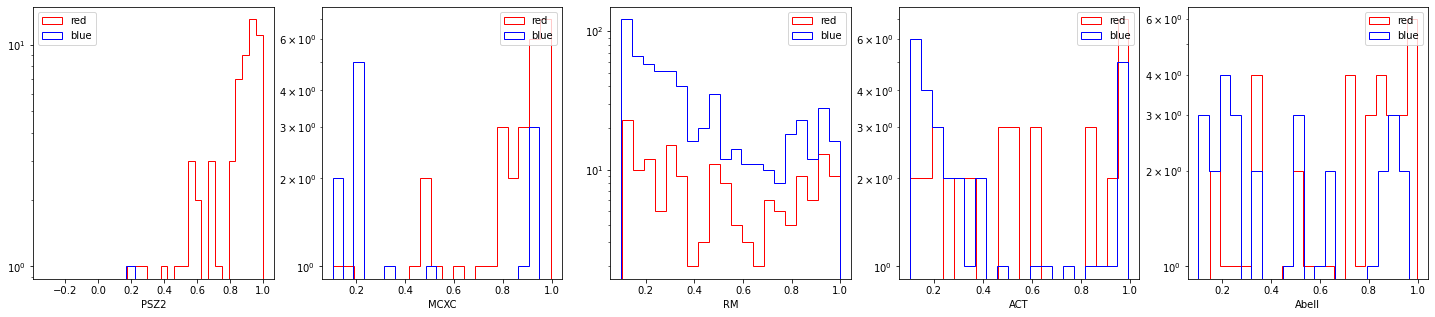

In [10]:
_, ax = plt.subplots(1, len(true_cats), figsize=(len(true_cats) * 5, 5))
for i, tr_cat in enumerate(true_cats):
    name=os.path.splitext(os.path.basename(tr_cat))[0]
    match_one_by_one(ax[i], cut_cat(pd.read_csv(det_cat), big_pix = 38), 
                     cut_cat(pd.read_csv(tr_cat), big_pix = 38), name=name)
    ax[i].set_xlabel(name)

Text(0.5, 0, 'PSZ2')

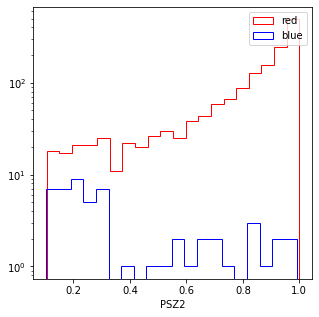

In [32]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))
match_one_by_one(ax, pd.read_csv(det_cat), 
                 pd.read_csv('/home/rt2122/Data/original_catalogs/csv/PSZ2.csv'))
ax.set_xlabel('PSZ2')

PSZ2
MCXC
RM
ACT
Abell


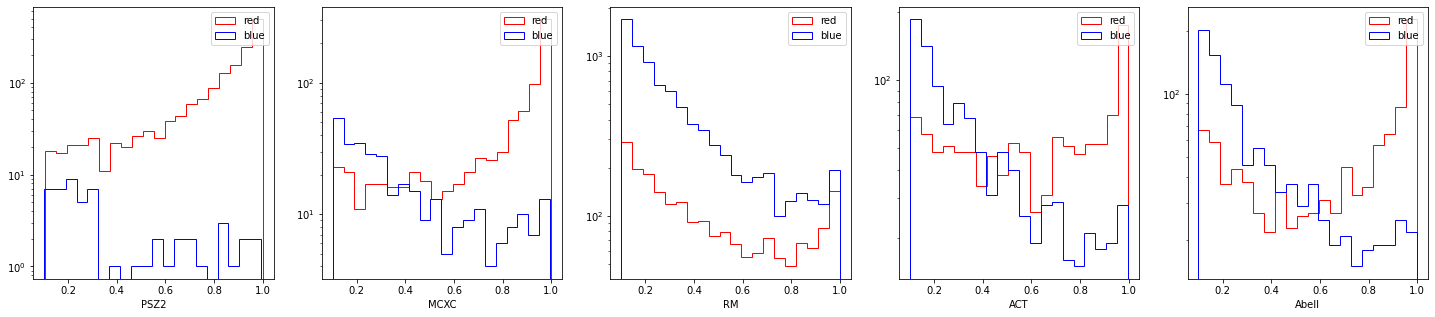

In [24]:
_, ax = plt.subplots(1, len(true_cats), figsize=(len(true_cats) * 5, 5))
for i, tr_cat in enumerate(true_cats):
    name=os.path.splitext(os.path.basename(tr_cat))[0]
    print(name)
    match_one_by_one(ax[i], pd.read_csv(det_cat), pd.read_csv(tr_cat), name=name)
    ax[i].set_xlabel(name)

In [19]:
'{}'.format(None)

'None'